In [1]:
import json, re, math, random
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk import tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import naive_bayes, svm
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, MaxPool1D, Dropout, Conv1D, SpatialDropout1D, LSTM, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model

from keras.layers import Input, TimeDistributed
from keras.models import Model

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

F:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
F:\Programs\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
F:\Programs\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
F:\Programs\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Data Import

The data is composed of two files: plot_summaries.txt, which contains the plaintext summary with an index, and movie_metadata.tsv, which contains the genre listing (along with other data). We combine these two files and save only the summaries and plot info.

In [31]:
summaries = {}
with open("plot_summaries.txt", encoding='utf8') as f:
    for line in f.readlines():
        s = line.split('\t')
        summaries[s[0]] = s[1].strip()
summaries_df = pd.DataFrame([summaries], columns=summaries.keys()).transpose()
summaries_df.columns = ["plot_summary"]
summaries_df.index = summaries_df.index.astype("int64") # recast the index to int

summaries_df.sample(2)

,plot_summary
7556999,"An American boy, Cody , whose parents have die..."
940106,"Chuck , an uptight college student in Los Ange..."


In [46]:
meta_data = pd.read_csv("movie.metadata.tsv", sep='\t', header=None)
meta_data.columns = ["wikipedia_id", "freebase_id", "name", "release", "revenue", "runtime", "languages", "countries", "genres"]
meta_data.set_index("wikipedia_id", inplace=True)

#parse the genres from json
meta_data.genres = meta_data.genres.apply(lambda x: list(json.loads(x).values()))
meta_data.sample(5)

,freebase_id,name,release,revenue,runtime,languages,countries,genres
wikipedia_id,,,,,,,,
13021375,/m/02z3p78,The King of the Kitchen,1918-10-30,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Short Film, Silent film, Indie, Black-and-white]"
34443947,/m/0gd2893,A Royal Affair,2012-03-29,NaN,128.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/01mjq"": ""Czech Republic"", ""/m/0k6nt"": ""De...","[Historical Documentaries, Romance Film, Drama..."
26251984,/m/0b74q96,Men Don't Lie,NaN,NaN,NaN,{},"{""/m/0f8l9c"": ""France"", ""/m/06mzp"": ""Switzerla...",[Drama]
6506680,/m/0g7_9s,Crows and Sparrows,1949,NaN,113.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/0d05w3"": ""China""}","[Drama, Chinese Movies, Black-and-white]"
34597215,/m/0j270jm,A Homansu,1986-10-10,NaN,99.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}",[]


In [33]:
movies_df = summaries_df.merge(meta_data, left_index=True, right_index=True)[['name', 'plot_summary', 'genres']]
%xdel summaries_df
%xdel meta_data
movies_df.sample(5)

,name,plot_summary,genres
31270807,China: The Roots of Madness,"White referred to Empress Dowager Cixi as ""Chi...",[Documentary]
27902570,Five Hours from Paris,Yigal is a taxi driver with a burning desire t...,"[Romantic drama, Romance Film, Drama, World ci..."
25016098,U Me Aur Hum,{{polt}} The movie starts with Ajay telling h...,"[World cinema, Musical, Drama, Romantic drama,..."
33089019,Escapade romaine,French filmmaker Jérémie Carboni followed Fren...,"[Short Film, Documentary]"
32047926,Snowblind,A Post-Apocalyptic Spaghetti Western. Governor...,[Indie]


# Data Cleaning
The plot summary texts are a little messy

In [34]:
%%time
# There are some html type artifacts left in some of the plots - regex them out
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: re.sub(r"{{.*?}}|<.*?}}|{{.*?>", '', x))

Wall time: 1.22 s


In [41]:
%%time
# remove all proper nouns and tokenize. Join on spaces so we can get individual tokens back quickly if we want
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: ' '.join(['NNP' if token[1]=='NNP' else token[0] for token in nltk.pos_tag(nltk.word_tokenize(x))]))

Wall time: 16min 9s


In [69]:
movies_df.sample()['plot_summary'].values[0]

"Five years after the events of The NNP and the NNP , NNP NNP and his new crew , NNP `` NNP '' NNP , NNP `` NNP '' , NNP NNP , NNP NNP and NNP NNP , are hijacking fuel tankers in the NNP NNP . NNP begins to suspect the trail is too hot and leaves NNP behind in order to protect her from harm . Several weeks later , in NNP NNP , NNP gets a call from NNP , who tells him that NNP has been murdered by NNP NNP , after getting into a near fatal car accident . NNP heads back to NNP NNP to examine NNP 's crash and finds traces of nitromethane . He then goes to the only car mechanic that uses nitromethane and coerces him into giving him the name NNP NNP , the man who ordered the fuel . Meanwhile , NNP . agent NNP NNP is trying to track down a drug dealer named NNP NNP . His search leads him to NNP NNP . NNP arrives at NNP 's apartment first and hangs him out of the window by his ankles before letting go . NNP , who was also on his way to NNP 's place , saves NNP and NNP becomes the NNP 's new in

# Consolidate Genre Labels
There's over 300 distinct genres in the dataset, so we need to filter them down to a smaller subset of genres.

In [51]:
#initialize the assigned genre column with nans
movies_df['assigned_genres'] = ''

count=0
for i,movie in movies_df.iterrows():
    assigned = []
    for genre in movie.genres:
        if "drama" in genre.lower() or genre in ['Period piece', 'Epic']:
            assigned.append("Drama")
        if "comedy" in genre.lower():
            assigned.append("Comedy")
        if "roman" in genre.lower() or genre in ['']:
            assigned.append("Romance")
        if "action" in genre.lower() or genre in ["Samurai cinema", "War film"]:
            assigned.append("Action")
        if "thrill" in genre.lower():
            assigned.append("Thriller")
        if genre in ["Indie", "Short Film", "Art film"]:
            assigned.append("Indie")
        if "docu" in genre.lower():
            assigned.append("Documentary")
        if "horror" in genre.lower():
            assigned.append("Horror")
        if "adven" in genre.lower():
            assigned.append("Adventure")
        if "family" in genre.lower() or "children" in genre.lower():
            assigned.append("Family") # animation
        if "music" in genre.lower():
            assigned.append("Musical")
        if "mystery" in genre.lower():
            assigned.append("Mystery")
        if "sci" in genre.lower() or genre in ["Monster movie"]:
            assigned.append("Science Fiction")
        if "fantasy" in genre.lower():
            assigned.append("Fantasy")
        if "western" in genre.lower():
            assigned.append("Western")
        if genre in ['Bollywood', 'Chinese Movies', 'Japanese Movies', 'World cinema']:
            assigned.append("World Cinema")
        if "animat" in genre.lower():
            assigned.append("Animated")
        if "teen" in genre.lower():
            assigned.append("Teen")
        
    if len(assigned) > 0:
        movies_df.at[i,'assigned_genres'] = list(set(assigned))
    else:
        movies_df.at[i,'assigned_genres'] = np.nan
    
    count+=1
    if count %10000==0 or count==movies_df.shape[0]:
        print("{} of {}".format(count, movies_df.shape[0]))
        
# drop any films which haven't recieved a genre tag
movies_df = movies_df[movies_df['assigned_genres'].notnull()]

10000 of 40907
20000 of 40907
30000 of 40907
40000 of 40907
40907 of 40907


In [52]:
movies_df.drop(columns=['genres'], inplace=True)
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: ','.join(x))
movies_df.sample(3)

,name,plot_summary,assigned_genres
2125458,Blood and Sand,"NNP NNP , a village boy born into poverty , gr...","Drama,Indie,Romance"
31250146,Assassin for Hire,"NNP NNP , a young British criminal of Italian ...",Mystery
3117366,The ChubbChubbs!,"NNP , the janitor of an alien pub called the N...","Family,Animated,Comedy,Indie,Fantasy"


In [53]:
# there are nine plot summaries that are blank. Remove them from the set
movies_df = movies_df[movies_df['plot_summary'].apply(lambda x: len(x))!=0]

In [54]:
# Save the dataframe at this point to save time in the future
movies_df.to_csv("movies_cleaned.csv")

# Data Exploration

In [55]:
movies_df = pd.read_csv("movies_cleaned.csv", index_col=0)

In [56]:
# counts for each movie genre
counts = {}
for x in movies_df.assigned_genres.values:
    for genre in x.split(','):
        if genre in counts:
            counts[genre] += 1
        else:
            counts[genre] = 1
genre_count = pd.DataFrame(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))
genre_count.columns = ['Genre', 'Count']

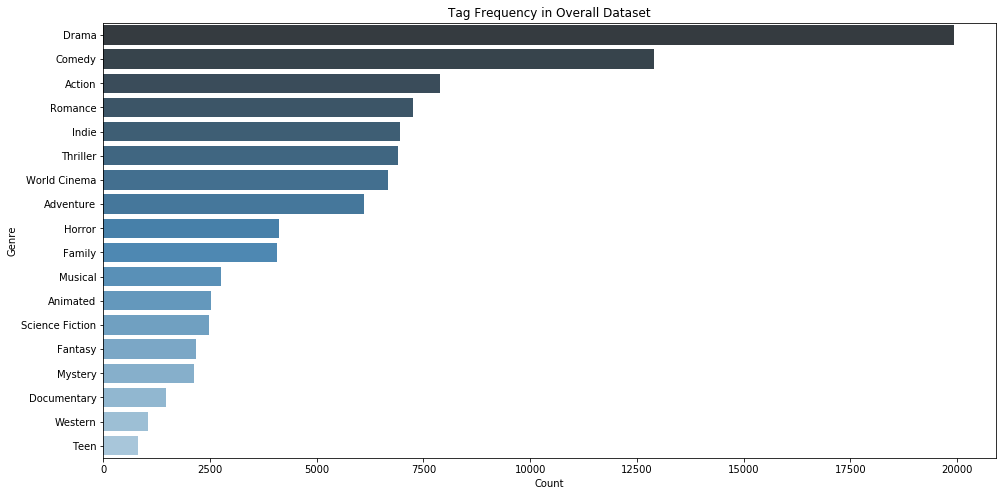

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
g = sns.barplot(genre_count.Count, genre_count.Genre, palette="Blues_d", orient='h', ax=ax)
g.set_title("Tag Frequency in Overall Dataset")
plt.savefig("tag_freq.png", bbox_inches='tight')

In [58]:
# get a count of how many tokens are in each plot summary
movies_df['plot_token_count'] = movies_df['plot_summary'].apply(lambda x: len(x.split()))

In [59]:
# get a count of how many genre lables are in each movie
movies_df['genre_count'] = movies_df['assigned_genres'].apply(lambda x: len(x.split(',')))

In [60]:
# use the MultilabteBinarizer to get OneHots for the genre labels. 
# We're using this for data exploration here, but it's how we get our y values for the models later
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_df['assigned_genres'].apply(lambda x: x.split(',')))
labels = multilabel_binarizer.classes_
y = multilabel_binarizer.transform(movies_df['assigned_genres'].apply(lambda x: x.split(',')))
movies_df = movies_df.merge(pd.DataFrame(y, columns=labels, index=movies_df.index), left_index=True, right_index=True)

In [61]:
movies_df.sample(3)

,name,plot_summary,assigned_genres,plot_token_count,genre_count,Action,Adventure,Animated,Comedy,Documentary,...,Horror,Indie,Musical,Mystery,Romance,Science Fiction,Teen,Thriller,Western,World Cinema
18225554,It's Alive,Just before the end of her semester at college...,"Science Fiction,Horror",330,2,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
32508075,Virgin Island,A British woman marries an American writer in ...,"Drama,Adventure",25,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20632900,Mystic Pink,The NNP NNP lives in a rundown house at the ci...,"Animated,Comedy,Indie",157,3,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0


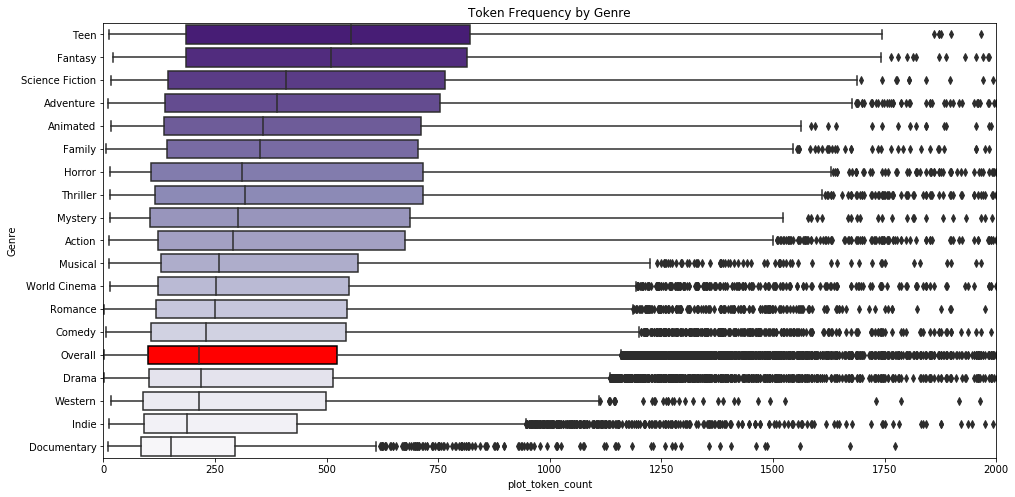

In [70]:
token_counts = []
for label in labels:
    token_counts += [(label,x) for x in movies_df[movies_df[label]==1]['plot_token_count'].values]
token_counts += [('Overall',x) for x in movies_df['plot_token_count'].values]

token_counts = pd.DataFrame(token_counts)
token_counts.columns = ['Genre', 'plot_token_count']

# get the means by genre so we can sort the boxplot
means = token_counts.groupby("Genre").mean().sort_values('plot_token_count', ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(16,8)
g = sns.boxplot(y='Genre', x='plot_token_count', data=token_counts, order=means.index, palette='Purples_r', ax=ax)
g.set_title("Token Frequency by Genre")
plt.xlim(0,2000)

# pick out the overall box and re-color it so it stands out
overall_box = ax.artists[14]
overall_box.set_facecolor('red')
overall_box.set_edgecolor('black')

plt.savefig("token_freq_comparison.png", bbox_inches='tight')

In [71]:
movies_df['genre_count'].describe()

count    40907.000000
mean         2.398905
std          1.254656
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: genre_count, dtype: float64

# Data Prep

In [2]:
# load in the cleaned and tokenized dataset
movies_df = pd.read_csv("movies_tokenized.csv", index_col=0)[['plot_summary', 'assigned_genres']]
# return the genre lables to a list 
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))
# drop all rows with a null value
movies_df.dropna(inplace=True)

In [3]:
# Create the labels - shouldn't change between implementations
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_df['assigned_genres'])
labels = multilabel_binarizer.classes_
y = multilabel_binarizer.transform(movies_df['assigned_genres'])

In [4]:
# Class Weights
counts = {k:0 for k in labels}
for i,row in movies_df['assigned_genres'].iteritems():
    for g in row:
        counts[g] += 1
# convert into percentages
counts = {k:v/sum(counts.values()) for k,v in counts.items()}

# create a dict the model can use
class_weight ={}
for index, label in enumerate(labels):
    class_weight[index] = counts[label]

In [5]:
# the same function keras scores categorical accuracy with
# not the same as sklearn
def cat_accuracy(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).astype(int).sum()/y_true.shape[0]

In [6]:
def top_k_categorical_accuracy(y_true, y_pred, k=5):
    top_k = np.flip(np.argsort(y_pred))[:k]
    target_k = np.flip(np.argsort(y_true))[:k]
    count = 0
    for t in target_k:
        if t in top_k:
            count += 1
    return count/k

## Topic Modeling

### Tokenize / N-gram detection

In [2]:
movies_df = pd.read_csv("movies_cleaned.csv", index_col=0)
movies_df.sample(3)

,name,plot_summary,assigned_genres
29173696,Hindle Wakes,NNP mill-girls NNP NNP and NNP NNP go on holid...,"Drama,Romance"
9475022,Off Season,After the death of his parents in a car crash ...,"Drama,Family,Comedy"
31341418,Nool Veli,The story deals with the crisis of a middle-ag...,Drama


In [79]:
%%time
stemmer = PorterStemmer()
movies_df['plot_summary_stemmed'] = movies_df['plot_summary'].apply(lambda x: [stemmer.stem(t) for t in nltk.word_tokenize(x)])

Wall time: 8min


In [80]:
%%time
# from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
bigram = gensim.models.Phrases([x for x in movies_df['plot_summary']], min_count=30)
bigram_mod = gensim.models.phrases.Phraser(bigram)

Wall time: 2min 17s


In [81]:
movies_df['plot_summary'] = movies_df['plot_summary_stemmed'].apply(lambda x: re.sub(r'[^\w\s]|\r\n','',' '.join(x)).lower())
movies_df.drop(columns=['plot_summary_stemmed'], inplace=True)
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: bigram_mod[x.split()])
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: ' '.join(x))

In [82]:
movies_df.head()

,name,plot_summary,assigned_genres
23890098,Taxi Blues,nnp a hardwork taxi driver and nnp a saxophoni...,"Drama,World Cinema"
31186339,The Hunger Games,the nation of nnp consist of a wealthi nnp and...,"Science Fiction,Action,Drama,Adventure"
20663735,Narasimham,nnp nnp is sentenc for six year prison life fo...,"Drama,World Cinema,Action,Musical"
2231378,The Lemon Drop Kid,the nnp nnp nnp a nnp nnp nnp swindler is ille...,Comedy
595909,A Cry in the Dark,seventhday nnp nnp pastor nnp nnp hi wife nnp ...,"Drama,World Cinema,Documentary"


In [83]:
movies_df.to_csv("movies_tokenized.csv")

### Test/Train Split

In [268]:
%%time
movies_df = pd.read_csv("movies_tokenized.csv", index_col=0)
movies_df.dropna(inplace=True)

# convert the summaries back into lists of tokens
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: x.split())

Wall time: 2.88 s


In [269]:
movies_df.sample(3)

,name,plot_summary,assigned_genres
560431,Stranger on the Third Floor,"[report, nnp, nnp, is, the, key, wit, in, a, m...","Thriller,Mystery,Drama"
26122958,On the Path,"[nnp, and, nnp, are, a, young, bosnian, coupl,...","Drama,Romance"
17458139,Rab Ne Bana Di Jodi,"[nnp, introvert, and, kindheart, nnp, nnp, nnp...","Drama,Musical,World Cinema,Comedy,Romance"


In [270]:
%%time
vocab=100000
num_topics=18

# using gensim, create the dictionary and the corpus to input into the LDA model
# from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
id2word = corpora.Dictionary(movies_df['plot_summary']) # Term-Document Frequency 
id2word.filter_extremes(no_below=5, no_above=0.25, keep_n=vocab)

print("Filtered to {} words...".format(len(id2word.keys())))

movies_df, test_movies_df = train_test_split(movies_df, train_size=0.9, random_state=630)

# creates a list of (int,int) tuples, where the first is the unique id of the word, and the second is the number of times it appears in the document
corpus = [id2word.doc2bow(text) for text in movies_df['plot_summary']]

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, iterations=100, passes=1)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, "vis_out.html")

topic_terms = {}
for topic in range(num_topics):
    topic_terms[topic] = [id2word[word[0]] for word in lda_model.get_topic_terms(topic, topn=10)]

for topic,terms in topic_terms.items():
    print(topic, ', '.join(terms))

Filtered to 17729 words...
0 brother, work, money, mother, day, goe, had, young, decid, call
1 father, mother, decid, turn, so, down, wife, name, own, daughter
2 hous, mother, had, begin, off, work, girl, famili, home, day
3 work, use, stori, himself, call, say, later, woman, new, show
4 hous, arriv, father, off, through, car, decid, run, call, had
5 wife, there, show, give, order, daughter, call, fall, work, want
6 polic, use, villag, forc, arriv, murder, so, decid, men, dure
7 famili, name, stori, work, through, dure, play, young, run, ship
8 had, work, money, stori, himself, name, father, play, doe, day
9 famili, father, had, escap, off, howev, begin, attempt, over, name
10 home, day, had, marri, famili, father, want, so, work, over
11 use, attempt, escap, himself, more, decid, fight, through, over, hous
12 attack, fight, off, day, howev, use, so, team, escap, famili
13 son, father, year, school, mother, famili, daughter, day, doe, home
14 hous, off, father, mother, nt, goe, show, s

In [271]:
%%time
topic_by_doc = {}
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: x[1], reverse=True)
    topic_by_doc[i] = [x[0] for x in row]

# https://stackoverflow.com/questions/19736080/creating-dataframe-from-a-dictionary-where-entries-have-different-lengths
doc_topics_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in topic_by_doc.items()])).transpose()
doc_topics_df.columns = ["Topic_"+str(x+1) for x in range(num_topics)]

Wall time: 1min 37s


In [272]:
results_df = movies_df
results_df.reset_index(inplace=True)
results_df = results_df.merge(doc_topics_df, left_index=True, right_index=True)

In [273]:
results_df.sample(3)

,index,name,plot_summary,assigned_genres,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,...,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18
788,860103,In the Time of the Butterflies,"[the, nnp, nnp, show, pictur, and, film, of, t...","Drama,Romance",10.0,17.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34835,16168084,Engal Anna,"[the, film, open, with, a, flashback, show, th...","Drama,Action,Adventure,World Cinema,Romance",10.0,0.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18006,1683542,Imaginary Heroes,"[nnp, nnp, is, goodlook, popular, and, hi, sch...","Drama,Family,Comedy",13.0,16.0,10.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
# Create the labels - shouldn't change between implementations
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(results_df['assigned_genres'].apply(lambda x: x.split(',')))
labels = multilabel_binarizer.classes_

In [275]:
results_df = results_df.merge(pd.DataFrame(y, columns=labels), left_index=True, right_index=True)

In [277]:
results_df.drop(columns=['index'], inplace=True)

In [278]:
# count the number of occurances for each topic with each label
topic_weights = {topic:{genre:0 for genre in labels} for topic in range(len(labels))}
for genre in labels:
    for i,row in results_df[results_df[genre]==1].iterrows():
        for topic_num in range(num_topics):
            topic_id = row.iloc[4+topic_num]
            if pd.notnull(topic_id):
#                 discount = 1/(math.log(topic_num+1)+1)
                discount = 1
                topic_weights[topic_id][genre] += discount

In [279]:
# normalize those counts to percents
for topic,weights in topic_weights.items():
    total_weight = sum(topic_weights[topic].values())
    topic_weights[topic] = {genre:weight/total_weight for genre,weight in weights.items()}

# Baseline Testing

# Random

In [253]:
movies_df, test_movies_df = train_test_split(movies_df, train_size=0.9, random_state=630)

In [267]:
true_y = multilabel_binarizer.transform(test_movies_df['assigned_genres'])

# random present/missing for every genre
pred_y = np.zeros(true_y.shape)
for i in range(true_y.shape[0]):
    for j in range(true_y.shape[1]):
        pred_y[i,j] = np.random.choice([0,1])
        
results = []
for x in range(true_y.shape[0]):
    results.append(top_k_categorical_accuracy(true_y[x], pred_y[x]))
    
np.mean(results)

0.33253483255927646

### Weighted Averages based on LDA Topics

In [280]:
# 0.60 Average Score: 0.3467190312131629

test_corpus = [id2word.doc2bow(text) for text in test_movies_df['plot_summary']]
test_topic_by_doc = {}
for i, row in enumerate(lda_model[test_corpus]):
    row = sorted(row, key=lambda x: x[1], reverse=True)
    test_topic_by_doc[i] = [x[0] for x in row]

test_doc_topics_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in test_topic_by_doc.items()])).transpose()
test_doc_topics_df.columns = ["Topic_"+str(x+1) for x in range(18)]

test_results_df = test_movies_df
test_results_df.reset_index(inplace=True)
test_results_df = test_results_df.merge(test_doc_topics_df, left_index=True, right_index=True)

In [288]:
threshold = 0.5

predictions = []
for i,movie in test_results_df.iterrows():
    weights = np.zeros(18)
    for topic_num in range(18):
        topic_id = movie.iloc[4+topic_num]
        if pd.notnull(topic_id):
            weights+=np.array([v for k,v in topic_weights[int(topic_id)].items()])
    
    prediction = (weights > threshold).astype(int)
    predictions.append(prediction)
    
predictions = np.stack(predictions)

true_y = multilabel_binarizer.transform(test_results_df['assigned_genres'].apply(lambda x: x.split(',')))

results = []
for x in range(true_y.shape[0]):
    results.append(top_k_categorical_accuracy(true_y[x], predictions[x]))
    
np.mean(results)

0.5674407235394768

# Multiple Binary

In [290]:
%%time
movies_df = pd.read_csv("movies_cleaned.csv", index_col=0)
vocab = 10000
# select 5000 discriminating vocab features with TF-IDF
tfidf = TfidfVectorizer(max_features=vocab, ngram_range=(1,2))
tfidf.fit(movies_df['plot_summary'])
x = tfidf.transform(movies_df['plot_summary'])

Wall time: 1min 8s


In [291]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)

In [292]:
%%time
classifiers = {}

train_predictions = np.zeros((y_train.shape[0],18))
test_predictions = np.zeros((y_test.shape[0],18))

for index, label in enumerate(labels):
    print(index, label)
    classifiers[label] = OneVsRestClassifier(BaggingClassifier(svm.LinearSVC()))
    classifiers[label].fit(x_train, y_train[:,index])
    
    train_predictions[:,index]=classifiers[label].predict(x_train)
    test_predictions[:,index]=classifiers[label].predict(x_test)

0 Action
1 Adventure
2 Animated
3 Comedy
4 Documentary
5 Drama
6 Family
7 Fantasy
8 Horror
9 Indie
10 Musical
11 Mystery
12 Romance
13 Science Fiction
14 Teen
15 Thriller
16 Western
17 World Cinema
Wall time: 6min 21s


In [294]:

results = []
for x in range(y_test.shape[0]):
    results.append(top_k_categorical_accuracy(y_test[x], test_predictions[x]))
    
np.mean(results)

0.664458567587387

# Keras Implementation

## Simple Neural Net
Vocab as input, TF-IDF to 20,000 most significant terms

In [175]:
# load in the cleaned and tokenized dataset
movies_df = pd.read_csv("movies_tokenized.csv", index_col=0)[['plot_summary', 'assigned_genres']]
# return the genre lables to a list 
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))
# drop all rows with a null value
movies_df.dropna(inplace=True)

In [176]:
%%time
vocab = 10000
# select vocab features with TF-IDF
tfidf = TfidfVectorizer(max_features=vocab, ngram_range=(1,2))
tfidf.fit(movies_df['plot_summary'])
x = tfidf.transform(movies_df['plot_summary'])

Wall time: 1min 3s


In [179]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=vocab))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(18, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
    "top_k_categorical_accuracy"
])

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(monitor='val_loss', patience=5), 
    ModelCheckpoint(filepath='model-simple.h5', save_best_only=True)
]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
__________

In [180]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)
model.fit(x_train, y_train,
          class_weight=class_weight,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

Train on 29452 samples, validate on 3273 samples
Epoch 1/20
29452/29452 [==============================] - 17s 581us/step - loss: 0.0365 - top_k_categorical_accuracy: 0.6640 - val_loss: 0.0311 - val_top_k_categorical_accuracy: 0.7553
Epoch 2/20
29452/29452 [==============================] - 14s 480us/step - loss: 0.0312 - top_k_categorical_accuracy: 0.7518 - val_loss: 0.0294 - val_top_k_categorical_accuracy: 0.7690
Epoch 3/20
29452/29452 [==============================] - 14s 474us/step - loss: 0.0288 - top_k_categorical_accuracy: 0.7809 - val_loss: 0.0292 - val_top_k_categorical_accuracy: 0.8185
Epoch 4/20
29452/29452 [==============================] - 13s 453us/step - loss: 0.0268 - top_k_categorical_accuracy: 0.8044 - val_loss: 0.0293 - val_top_k_categorical_accuracy: 0.8100
Epoch 5/20
29452/29452 [==============================] - 14s 469us/step - loss: 0.0252 - top_k_categorical_accuracy: 0.8206 - val_loss: 0.0295 - val_top_k_categorical_accuracy: 0.8185
Epoch 6/20
29452/29452 [==

In [181]:
model = load_model('model-simple.h5')
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 3s 353us/step
Accuracy on Test Set: 0.8092153507117041


## Cov1D Net

In [137]:
maxlen = 1000
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(movies_df['plot_summary'])
tokenized = tokenizer.texts_to_sequences(movies_df['plot_summary'])
x = pad_sequences(tokenized, maxlen=maxlen)

In [138]:
filter_length = 128

model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPool1D())
model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPool1D())
model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(18, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['top_k_categorical_accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=5), 
    ModelCheckpoint(filepath='model-conv1d.h5')
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 247, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 243, 128)          82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
__________

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 29452 samples, validate on 3273 samples
Epoch 1/20
29452/29452 [==============================] - 22s 746us/step - loss: 0.0375 - top_k_categorical_accuracy: 0.6247 - val_loss: 0.0330 - val_top_k_categorical_accuracy: 0.7107
Epoch 2/20
29452/29452 [==============================] - 19s 631us/step - loss: 0.0334 - top_k_categorical_accuracy: 0.7260 - val_loss: 0.0329 - val_top_k_categorical_accuracy: 0.7650
Epoch 3/20
29452/29452 [==============================] - 19s 633us/step - loss: 0.0317 - top_k_categorical_accuracy: 0.7561 - val_loss: 0.0308 - val_top_k_categorical_accuracy: 0.7715
Epoch 4/20
29452/29452 [==============================] - 19s 635us/step - loss: 0.0296 - top_k_categorical_accuracy: 0.7850 - val_loss: 0.0309 - val_top_k_categorical_accuracy: 0.7623
Epoch 5/20
29452/29452 [==============================] - 19s 635us/step - loss: 0.0276 - top_k_categorical_accuracy: 0.7999 - val_loss: 0.0308 - val_top_k_categorical_accuracy: 0.7999
Epoch 6/20
29452/29452 [==

In [140]:
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 2s 202us/step
Accuracy on Test Set: 0.791493522395309


# LSTM Network

In [182]:
maxlen = 500
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(movies_df['plot_summary'])
tokenized = tokenizer.texts_to_sequences(movies_df['plot_summary'])
x = pad_sequences(tokenized, maxlen=maxlen)

In [183]:
model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dense(18, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['top_k_categorical_accuracy'])

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=3), 
    ModelCheckpoint(filepath='model-lstm.h5', save_best_only=True)
]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 50)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 64)           21248     
_________________________________________________________________
dropout_53 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                4160      
__________

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

In [ ]:
model = load_model('model-lstm.h5')
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

# HAN Network

### Tokenize / Sentence Split

In [16]:
%%time
movies_df = pd.read_csv("movies_cleaned.csv", index_col=0)
movies_df = movies_df[['plot_summary', 'assigned_genres']]
# drop all rows with a null value
movies_df.dropna(inplace=True)

Wall time: 1.14 s


In [3]:
%%time
# There are some html type artifacts left in some of the plots - regex them out
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: re.sub(r"{{.*?}}|<.*?}}|{{.*?>", '', x))

Wall time: 45 s


In [4]:
%%time
# remove all proper nouns
movies_df['plot_summary'] = movies_df['plot_summary'].apply(lambda x: ' '.join(['<NNP>' if token[1]=='NNP' else token[0] for token in nltk.pos_tag(nltk.word_tokenize(x))]))

Wall time: 20min 58s


In [5]:
%%time
# split into sentences
movies_df['sent_tokenize'] = movies_df['plot_summary'].apply(lambda x: tokenize.sent_tokenize(x))

movies_df.reset_index(inplace=True)
movies_df.drop(columns=['index'], inplace=True)

Wall time: 34.8 s


In [20]:
movies_df['sent_tokenize'] = movies_df['sent_tokenize'].apply(lambda x: '|'.join(x))

In [30]:
movies_df.to_csv("movies_sent_tokens.csv")

In [297]:
movies_df = pd.read_csv("movies_sent_tokens.csv", index_col=0)

In [298]:
movies_df['sent_tokenize'] = movies_df['sent_tokenize'].apply(lambda x: x.split('|'))
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))

In [299]:
# how many sentences are in a summary on average
movies_df['sent_tokenize'].apply(lambda x: len(x)).describe()

count    40907.000000
mean        15.916347
std         16.784722
min          1.000000
25%          4.000000
50%          9.000000
75%         23.000000
max        344.000000
Name: sent_tokenize, dtype: float64

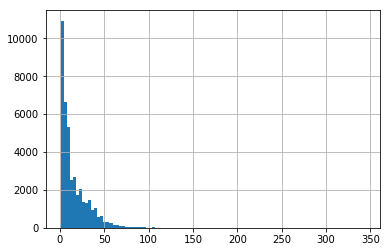

In [300]:
movies_df['sent_tokenize'].apply(lambda x: len(x)).hist(bins=100)

In [301]:
# how long are the sentences in a given summary
movies_df['sent_tokenize'].apply(lambda x: np.mean([len(s.split()) for s in x])).describe()

count    40907.000000
mean        28.509539
std          9.608177
min          3.000000
25%         23.000000
50%         27.000000
75%         32.000000
max        348.000000
Name: sent_tokenize, dtype: float64

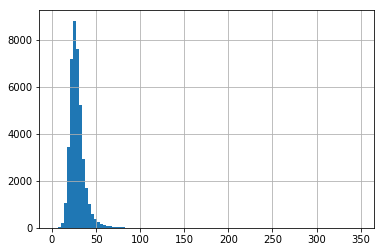

In [302]:
movies_df['sent_tokenize'].apply(lambda x: np.mean([len(s.split()) for s in x])).hist(bins=100)

In [303]:
%%time
# some constants for the model
max_vocab = 20000
max_sentences = 30
max_sentence_length = 50

# get a vocab for the summaries so we can replace word tokens with an index integer
tokenizer = Tokenizer(nb_words=max_vocab)
tokenizer.fit_on_texts(movies_df['plot_summary'])

# initilize the 3d x matrix with 0s (summary, sentence, word in sentence)
x = np.zeros((movies_df.shape[0], max_sentences, max_sentence_length), dtype='int32')

# iterate through all of the summaries
for i, summary in movies_df.iterrows():
    # and sentences in those summaries
    for sent_idx, sent in enumerate(summary['sent_tokenize']):
        # as long as we are in the first x lines of the summary
        if sent_idx < max_sentences:
            # tokenize the sentence
            tokens = text_to_word_sequence(sent)
            word_count=0
            for token_idx, token in enumerate(tokens):
                # get the index of the token 
                word_idx = tokenizer.word_index[token]
                # as long as we're under the max length for a sentence, add it on
                if word_count < max_sentence_length and word_idx<max_vocab:
                    x[i, sent_idx, word_count] = word_idx
                    word_count+=1

Wall time: 44.7 s


In [304]:
# get the labels the same way we did above
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_df['assigned_genres'])
labels = multilabel_binarizer.classes_
y = multilabel_binarizer.transform(movies_df['assigned_genres'])

In [305]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)

In [152]:
# Keras Functional API Guide: https://keras.io/getting-started/functional-api-guide/

# Model adapted from https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f

sentence_input = Input(shape=(max_sentence_length,), dtype='int32', name="sentence_input")
embedded_layer = Embedding(max_vocab, 100, input_length=max_sentence_length, trainable=True)
embedded_sequences = embedded_layer(sentence_input)
l_lstm = Bidirectional(LSTM(32))(embedded_sequences)
sent_encoder = Model(sentence_input, l_lstm)

summary_input = Input(shape=(max_sentences,max_sentence_length), dtype='int32', name="summary_input")
summary_encoder = TimeDistributed(sent_encoder)(summary_input)
l_lstm_sent = Bidirectional(LSTM(32))(summary_encoder)

dense_int1 = Dense(128, activation='relu', name="dense_intermediate1")(l_lstm_sent)
dense_dropout1 = Dropout(0.5)(dense_int1)

dense_int2 = Dense(64, activation='relu', name="dense_intermediate2")(dense_dropout1)
dense_dropout2 = Dropout(0.5)(dense_int2)

preds = Dense(18, activation='sigmoid', name="output")(dense_dropout2)

model = Model(summary_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['top_k_categorical_accuracy'])

callbacks = [
    EarlyStopping(patience=3), 
    ModelCheckpoint(filepath='model-han.h5', save_best_only=True)
]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
summary_input (InputLayer)   (None, 30, 50)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 64)            2034048   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_intermediate1 (Dense)  (None, 128)               8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_intermediate2 (Dense)  (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
__________

In [153]:
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 29452 samples, validate on 3273 samples
Epoch 1/10
29452/29452 [==============================] - 183s 6ms/step - loss: 0.6603 - top_k_categorical_accuracy: 0.6750 - val_loss: 0.6071 - val_top_k_categorical_accuracy: 0.7183
Epoch 2/10
29452/29452 [==============================] - 178s 6ms/step - loss: 0.6153 - top_k_categorical_accuracy: 0.7421 - val_loss: 0.5979 - val_top_k_categorical_accuracy: 0.7492
Epoch 3/10
29452/29452 [==============================] - 174s 6ms/step - loss: 0.6012 - top_k_categorical_accuracy: 0.7633 - val_loss: 0.5957 - val_top_k_categorical_accuracy: 0.7721
Epoch 4/10
29452/29452 [==============================] - 180s 6ms/step - loss: 0.5864 - top_k_categorical_accuracy: 0.7754 - val_loss: 0.5943 - val_top_k_categorical_accuracy: 0.7602
Epoch 5/10
29452/29452 [==============================] - 179s 6ms/step - loss: 0.5678 - top_k_categorical_accuracy: 0.7917 - val_loss: 0.5860 - val_top_k_categorical_accuracy: 0.7925
Epoch 6/10
29452/29452 [=======

In [306]:
model = load_model('model-han.h5')
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 29s 4ms/step
Accuracy on Test Set: 0.7858714251522911


## Simple Neural Net (BP-MLL Loss)
Vocab as input, TF-IDF to 20,000 most significant terms

BP-MLL Loss function from https://github.com/vanHavel/bp-mll-tensorflow

In [69]:
import numpy as np
from keras import backend as K

# bp mll loss function
# y_true, y_pred must be 2D tensors of shape (batch dimension, number of labels)
# y_true must satisfy y_true[i][j] == 1 iff sample i has label j
def bp_mll_loss(y_true, y_pred):

    # get true and false labels
    y_i = K.equal(y_true, K.ones_like(y_true))
    y_i_bar = K.not_equal(y_true, K.ones_like(y_true))

    # cast to float as keras backend has no logical and
    y_i = K.cast(y_i, dtype='float32')
    y_i_bar = K.cast(y_i_bar, dtype='float32')

    # get indices to check
    truth_matrix = pairwise_and(y_i, y_i_bar)

    # calculate all exp'd differences
    sub_matrix = pairwise_sub(y_pred, y_pred)
    exp_matrix = K.exp(-sub_matrix)

    # check which differences to consider and sum them
    sparse_matrix = exp_matrix * truth_matrix
    sums = K.sum(sparse_matrix, axis=[1,2])

    # get normalizing terms and apply them
    y_i_sizes = K.sum(y_i, axis=1)
    y_i_bar_sizes = K.sum(y_i_bar, axis=1)
    normalizers = y_i_sizes * y_i_bar_sizes
    results = sums / normalizers

    # average error
    return K.mean(results)

# compute pairwise differences between elements of the tensors a and b
def pairwise_sub(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return column - row

# compute pairwise logical and between elements of the tensors a and b
def pairwise_and(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return K.minimum(column, row)

In [70]:
# load in the cleaned and tokenized dataset
movies_df = pd.read_csv("movies_tokenized.csv", index_col=0)[['plot_summary', 'assigned_genres']]
# return the genre lables to a list 
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))
# drop all rows with a null value
movies_df.dropna(inplace=True)

In [71]:
%%time
vocab = 10000
# select vocab features with TF-IDF
tfidf = TfidfVectorizer(max_features=vocab, ngram_range=(1,2))
tfidf.fit(movies_df['plot_summary'])
x = tfidf.transform(movies_df['plot_summary'])

Wall time: 1min 2s


In [75]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=vocab, name="Input"))
# model.add(Dropout(0.1, name=".5_Dropout1"))
# model.add(Dense(128, activation='relu', name="Dense_1"))
# model.add(Dropout(0.5, name=".5_Dropout2"))
# model.add(Dense(64, activation='relu', name="Dense_2"))
# model.add(Dropout(0.5, name=".5_Dropout3"))
# model.add(Dense(32, activation='relu', name="Dense_3"))
# model.add(Dropout(0.1, name=".3_Dropout4"))
model.add(Dense(18, activation='sigmoid', name="Output"))
model.compile(optimizer='adam', loss=bp_mll_loss, metrics=['top_k_categorical_accuracy'])

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(monitor='val_loss', patience=2), 
    ModelCheckpoint(filepath='model-simple-bp-mll.h5', save_best_only=True)
]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 256)               2560256   
_________________________________________________________________
Output (Dense)               (None, 18)                4626      
Total params: 2,564,882
Trainable params: 2,564,882
Non-trainable params: 0
_________________________________________________________________


In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)
model.fit(x_train, y_train,
          class_weight=class_weight,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          callbacks=callbacks,
          verbose=1)

Train on 29452 samples, validate on 3273 samples
Epoch 1/20
29452/29452 [==============================] - 16s 547us/step - loss: 0.0813 - top_k_categorical_accuracy: 0.8473 - val_loss: 0.0735 - val_top_k_categorical_accuracy: 0.8866
Epoch 2/20
29452/29452 [==============================] - 13s 454us/step - loss: 0.0687 - top_k_categorical_accuracy: 0.9160 - val_loss: 0.0710 - val_top_k_categorical_accuracy: 0.8967
Epoch 3/20
29452/29452 [==============================] - 14s 461us/step - loss: 0.0633 - top_k_categorical_accuracy: 0.9441 - val_loss: 0.0704 - val_top_k_categorical_accuracy: 0.8909
Epoch 4/20
29452/29452 [==============================] - 14s 461us/step - loss: 0.0599 - top_k_categorical_accuracy: 0.9586 - val_loss: 0.0709 - val_top_k_categorical_accuracy: 0.8833
Epoch 5/20
29452/29452 [==============================] - 13s 448us/step - loss: 0.0574 - top_k_categorical_accuracy: 0.9679 - val_loss: 0.0716 - val_top_k_categorical_accuracy: 0.8900


In [74]:
model = load_model('model-simple-bp-mll.h5', custom_objects={'bp_mll_loss':bp_mll_loss})
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 2s 283us/step
Accuracy on Test Set: 0.884991444619994


In [43]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Cov1D Net with BP-MLL

In [48]:
maxlen = 1000
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(movies_df['plot_summary'])
tokenized = tokenizer.texts_to_sequences(movies_df['plot_summary'])
x = pad_sequences(tokenized, maxlen=maxlen)

In [66]:
filter_length = 128

model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
# model.add(MaxPool1D())
# model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
# model.add(MaxPool1D())
# model.add(Conv1D(filter_length, 5, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(18, activation='sigmoid'))

model.compile(optimizer='adam', loss=bp_mll_loss, metrics=['top_k_categorical_accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=2), 
    ModelCheckpoint(filepath='model-conv1d-bp-mll.h5', save_best_only=True)
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 18)                4626      
Total params: 1,069,778
Trainable params: 1,069,778
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 29452 samples, validate on 3273 samples
Epoch 1/20
29452/29452 [==============================] - 14s 465us/step - loss: 0.0893 - top_k_categorical_accuracy: 0.7729 - val_loss: 0.0830 - val_top_k_categorical_accuracy: 0.8469
Epoch 2/20
29452/29452 [==============================] - 12s 396us/step - loss: 0.0797 - top_k_categorical_accuracy: 0.8493 - val_loss: 0.0785 - val_top_k_categorical_accuracy: 0.8723
Epoch 3/20
29452/29452 [==============================] - 12s 395us/step - loss: 0.0742 - top_k_categorical_accuracy: 0.8855 - val_loss: 0.0773 - val_top_k_categorical_accuracy: 0.8656
Epoch 4/20
29452/29452 [==============================] - 12s 394us/step - loss: 0.0705 - top_k_categorical_accuracy: 0.9067 - val_loss: 0.0772 - val_top_k_categorical_accuracy: 0.8592
Epoch 5/20
29452/29452 [==============================] - 12s 393us/step - loss: 0.0674 - top_k_categorical_accuracy: 0.9254 - val_loss: 0.0774 - val_top_k_categorical_accuracy: 0.8442
Epoch 6/20
29452/29452 [==

In [68]:
model = load_model('model-conv1d-bp-mll.h5', custom_objects={'bp_mll_loss':bp_mll_loss})
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 2s 202us/step
Accuracy on Test Set: 0.8648252260915168


# HAN with BP-MLL

In [317]:
movies_df = pd.read_csv("movies_sent_tokens.csv", index_col=0)
movies_df['sent_tokenize'] = movies_df['sent_tokenize'].apply(lambda x: x.split('|'))
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))

In [318]:
%%time
# some constants for the model
max_vocab = 20000
max_sentences = 30
max_sentence_length = 50

# get a vocab for the summaries so we can replace word tokens with an index integer
tokenizer = Tokenizer(nb_words=max_vocab)
tokenizer.fit_on_texts(movies_df['plot_summary'])

# initilize the 3d x matrix with 0s (summary, sentence, word in sentence)
x = np.zeros((movies_df.shape[0], max_sentences, max_sentence_length), dtype='int32')

# iterate through all of the summaries
for i, summary in movies_df.iterrows():
    # and sentences in those summaries
    for sent_idx, sent in enumerate(summary['sent_tokenize']):
        # as long as we are in the first x lines of the summary
        if sent_idx < max_sentences:
            # tokenize the sentence
            tokens = text_to_word_sequence(sent)
            word_count=0
            for token_idx, token in enumerate(tokens):
                # get the index of the token 
                word_idx = tokenizer.word_index[token]
                # as long as we're under the max length for a sentence, add it on
                if word_count < max_sentence_length and word_idx<max_vocab:
                    x[i, sent_idx, word_count] = word_idx
                    word_count+=1

Wall time: 42.9 s


In [319]:
# get the labels the same way we did above
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_df['assigned_genres'])
labels = multilabel_binarizer.classes_
y = multilabel_binarizer.transform(movies_df['assigned_genres'])

In [320]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=630)

In [321]:
# Keras Functional API Guide: https://keras.io/getting-started/functional-api-guide/

# Model adapted from https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f

sentence_input = Input(shape=(max_sentence_length,), dtype='int32', name="sentence_input")
embedded_layer = Embedding(max_vocab, 100, input_length=max_sentence_length, trainable=True)
embedded_sequences = embedded_layer(sentence_input)
l_lstm = Bidirectional(LSTM(32))(embedded_sequences)
sent_encoder = Model(sentence_input, l_lstm)

summary_input = Input(shape=(max_sentences,max_sentence_length), dtype='int32', name="summary_input")
summary_encoder = TimeDistributed(sent_encoder)(summary_input)
l_lstm_sent = Bidirectional(LSTM(32))(summary_encoder)

dense_int1 = Dense(128, activation='relu', name="dense_intermediate1")(l_lstm_sent)
dense_dropout1 = Dropout(0.5)(dense_int1)

dense_int2 = Dense(64, activation='relu', name="dense_intermediate2")(dense_dropout1)
dense_dropout2 = Dropout(0.5)(dense_int2)

preds = Dense(18, activation='sigmoid', name="output")(dense_dropout2)

model = Model(summary_input, preds)
model.compile(loss=bp_mll_loss, optimizer='adam', metrics=['top_k_categorical_accuracy'])

callbacks = [
    EarlyStopping(patience=3), 
    ModelCheckpoint(filepath='model-han-bp-mll.h5', save_best_only=True)
]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
summary_input (InputLayer)   (None, 30, 50)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 64)            2034048   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_intermediate1 (Dense)  (None, 128)               8320      
_________________________________________________________________
dropout_59 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_intermediate2 (Dense)  (None, 64)                8256      
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
__________

In [322]:
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 29452 samples, validate on 3273 samples
Epoch 1/10
29452/29452 [==============================] - 185s 6ms/step - loss: 0.0974 - top_k_categorical_accuracy: 0.6916 - val_loss: 0.0915 - val_top_k_categorical_accuracy: 0.7715
Epoch 2/10
29452/29452 [==============================] - 178s 6ms/step - loss: 0.0897 - top_k_categorical_accuracy: 0.7779 - val_loss: 0.0857 - val_top_k_categorical_accuracy: 0.7932
Epoch 3/10
29452/29452 [==============================] - 180s 6ms/step - loss: 0.0842 - top_k_categorical_accuracy: 0.8204 - val_loss: 0.0822 - val_top_k_categorical_accuracy: 0.8399
Epoch 4/10
29452/29452 [==============================] - 176s 6ms/step - loss: 0.0807 - top_k_categorical_accuracy: 0.8498 - val_loss: 0.0816 - val_top_k_categorical_accuracy: 0.8405
Epoch 5/10
29452/29452 [==============================] - 172s 6ms/step - loss: 0.0786 - top_k_categorical_accuracy: 0.8660 - val_loss: 0.0812 - val_top_k_categorical_accuracy: 0.8384
Epoch 6/10
29452/29452 [=======

In [324]:
model = load_model('model-han-bp-mll.h5', custom_objects={'bp_mll_loss':bp_mll_loss})
test_score = model.evaluate(x_test, y_test)
print("Accuracy on Test Set:",test_score[1])

8182/8182 [==============================] - 26s 3ms/step
Accuracy on Test Set: 0.8306037643899313


# Results

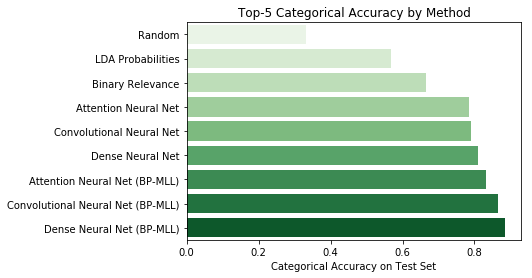

In [76]:
results = {
    "Random":0.33253483255927646,
    "LDA Probabilities":0.5674407235394768,
    "Binary Relevance":0.664458567587387,
    "Dense Neural Net":0.8092153507117041,
    "Dense Neural Net (BP-MLL)":0.8859692007572777,
    "Convolutional Neural Net":0.791493522395309,
    "Convolutional Neural Net (BP-MLL)":0.8648252260915168,
    "Attention Neural Net":0.7858714251522911,
    "Attention Neural Net (BP-MLL)":0.8306037643899313
}
results = pd.DataFrame([results], columns=results.keys(), index=['Categorical Accuracy']).transpose()
results = results.sort_values("Categorical Accuracy")
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
g = sns.barplot(x='Categorical Accuracy', y=results.index, data=results, palette="Greens", ax=ax)
g.set_title("Top-5 Categorical Accuracy by Method")
g.set_xlabel("Categorical Accuracy on Test Set")
plt.savefig("results.png", bbox_inches='tight')

# Error Analysis

In [77]:
# load in the cleaned and tokenized dataset
movies_df = pd.read_csv("movies_tokenized.csv", index_col=0)[['plot_summary', 'assigned_genres']]
# return the genre lables to a list 
movies_df['assigned_genres'] = movies_df['assigned_genres'].apply(lambda x: x.split(','))
# drop all rows with a null value
movies_df.dropna(inplace=True)

In [78]:
movies_df = movies_df.merge(pd.read_csv("movies_cleaned.csv", index_col=0)[['name']], left_index=True, right_index=True)

In [79]:
vocab = 10000
# select vocab features with TF-IDF
tfidf = TfidfVectorizer(max_features=vocab, ngram_range=(1,2))
tfidf.fit(movies_df['plot_summary'])
x = tfidf.transform(movies_df['plot_summary'])

In [80]:
model = load_model('model-simple-bp-mll.h5', custom_objects={'bp_mll_loss':bp_mll_loss})

In [81]:
pred_y = (model.predict(x, verbose=1) > 0.5).astype(int)

40907/40907 [==============================] - 8s 198us/step


In [82]:
y = multilabel_binarizer.transform(movies_df['assigned_genres'])

In [83]:
temp_df = pd.DataFrame(y, columns=["true_"+x for x in labels]).merge(pd.DataFrame(pred_y, columns=["pred_"+x for x in labels]), left_index=True, right_index=True)

In [84]:
movies_df.reset_index(inplace=True)

In [85]:
movies_df = movies_df.merge(temp_df, left_index=True, right_index=True)

In [86]:
movies_df['accuracy'] = 0

In [103]:
for i,movie in movies_df.iterrows():
    true = movie[4:22].values
    pred = movie[22:40].values
    acc = top_k_categorical_accuracy(y_pred=pred, y_true=true)
    movies_df.loc[i,'accuracy'] = acc
    if i % 10000 == 0:
        print(i)

0
10000
20000
30000
40000


In [88]:
movies_df['plot_len'] = movies_df['plot_summary'].apply(lambda x: len(x.split()))

In [89]:
movies_df['num_genres'] = movies_df['assigned_genres'].apply(lambda x: len(x))

In [90]:
good_predictions = movies_df[movies_df['accuracy'] == 1.0]

In [91]:
bad_predictions = movies_df[movies_df['accuracy'] == 0.0]

In [92]:
good_predictions.describe()

,index,true_Action,true_Adventure,true_Animated,true_Comedy,true_Documentary,true_Drama,true_Family,true_Fantasy,true_Horror,...,pred_Mystery,pred_Romance,pred_Science Fiction,pred_Teen,pred_Thriller,pred_Western,pred_World Cinema,accuracy,plot_len,num_genres
count,3.138000e+03,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,...,3138.000000,3138.000000,3138.000000,3138.0,3138.000000,3138.000000,3138.000000,3138.0,3138.000000,3138.000000
mean,1.265751e+07,0.252709,0.176227,0.118866,0.497451,0.011791,0.784576,0.148821,0.047164,0.065010,...,0.051625,0.330465,0.071383,0.0,0.197578,0.028362,0.320268,1.0,362.095602,3.285532
std,1.059789e+07,0.434635,0.381074,0.323682,0.500073,0.107961,0.411182,0.355969,0.212023,0.246582,...,0.221304,0.470456,0.257505,0.0,0.398236,0.166031,0.466654,0.0,320.584800,1.102084
min,4.726000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,15.000000,1.000000
25%,3.171652e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,112.000000,3.000000
50%,9.710182e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,255.000000,3.000000
75%,2.091423e+07,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.0,565.750000,4.000000
max,3.721033e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.0,3141.000000,8.000000


In [93]:
bad_predictions.describe()

,index,true_Action,true_Adventure,true_Animated,true_Comedy,true_Documentary,true_Drama,true_Family,true_Fantasy,true_Horror,...,pred_Mystery,pred_Romance,pred_Science Fiction,pred_Teen,pred_Thriller,pred_Western,pred_World Cinema,accuracy,plot_len,num_genres
count,6.600000e+01,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,66.000000,66.000000,66.000000,66.0,66.000000,66.000000,66.000000,66.0,66.000000,66.000000
mean,1.987777e+07,0.181818,0.075758,0.030303,0.106061,0.090909,0.242424,0.045455,0.090909,0.181818,...,0.257576,0.272727,0.136364,0.0,0.560606,0.015152,0.136364,0.0,168.242424,1.500000
std,1.187755e+07,0.388650,0.266638,0.172733,0.310275,0.289683,0.431834,0.209895,0.289683,0.388650,...,0.440650,0.448775,0.345804,0.0,0.500117,0.123091,0.345804,0.0,205.388941,0.827415
min,4.271730e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,18.000000,1.000000
25%,8.355630e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,50.750000,1.000000
50%,2.232744e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,106.500000,1.000000
75%,2.895064e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.750000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,185.750000,2.000000
max,3.647473e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1332.000000,4.000000


In [94]:
good_predictions.sample(3)

,index,plot_summary,assigned_genres,name,true_Action,true_Adventure,true_Animated,true_Comedy,true_Documentary,true_Drama,...,pred_Mystery,pred_Romance,pred_Science Fiction,pred_Teen,pred_Thriller,pred_Western,pred_World Cinema,accuracy,plot_len,num_genres
302,11102452,down a dirti alleyway nnp the alley cat is sca...,"[Animated, Family, Comedy, Indie]",Baby Butch,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1.0,281,4
18315,3619129,nineyearold nnp nnp s mother ha abandon the fa...,"[Drama, World Cinema, Family]",Evelyn,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1.0,154,3
3121,34014280,nnp and her brother nnp and nnp are stuck in a...,"[Science Fiction, Animated, Indie, Fantasy]",Kyousogiga,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1.0,68,4


In [95]:
bad_predictions.sample(3)

,index,plot_summary,assigned_genres,name,true_Action,true_Adventure,true_Animated,true_Comedy,true_Documentary,true_Drama,...,pred_Mystery,pred_Romance,pred_Science Fiction,pred_Teen,pred_Thriller,pred_Western,pred_World Cinema,accuracy,plot_len,num_genres
39397,31820610,in the 19th centuri in nnp two girl name nnp n...,"[Drama, World Cinema]",Snow Flower and the Secret Fan,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0.0,185,2
28827,35743450,nnp nnp nnp is arrest for critic wound hi wife...,[Western],Valerie,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,27,1
14928,33403102,a man befriend a puppi of about 3 month old th...,"[Thriller, Horror, Science Fiction]",Atomic Dog,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,115,3


In [96]:
movies_df[movies_df['name']=="The Matrix"]

,index,plot_summary,assigned_genres,name,true_Action,true_Adventure,true_Animated,true_Comedy,true_Documentary,true_Drama,...,pred_Mystery,pred_Romance,pred_Science Fiction,pred_Teen,pred_Thriller,pred_Western,pred_World Cinema,accuracy,plot_len,num_genres
22499,30007,nnp programm nnp nnp is secretli a hacker know...,"[Thriller, Action, Science Fiction, Adventure]",The Matrix,1,1,0,0,0,0,...,0,0,1,0,1,0,0,1.0,700,4


In [97]:
movies_df.loc[29781]

index                                                               68485
plot_summary            nnp nnp nnp nnp of nnp ha creat nnp nnp a them...
assigned_genres         [Thriller, Science Fiction, Action, Adventure,...
name                                                        Jurassic Park
true_Action                                                             1
true_Adventure                                                          1
true_Animated                                                           0
true_Comedy                                                             0
true_Documentary                                                        0
true_Drama                                                              0
true_Family                                                             0
true_Fantasy                                                            0
true_Horror                                                             1
true_Indie                            

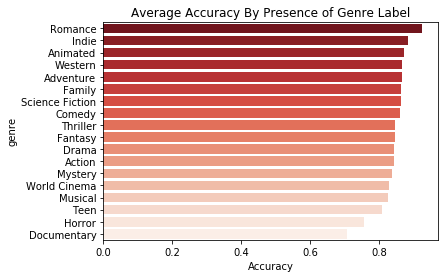

In [107]:
results = []
for genre in labels:
    results.append({
        "genre":genre,
        "avg_accuracy":movies_df[movies_df['true_'+genre]==1].accuracy.mean()
    })
results = pd.DataFrame(results).sort_values("avg_accuracy", ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
g = sns.barplot(x=results.avg_accuracy, y=results.genre, ax=ax, palette="Reds_r")
g.set_title("Average Accuracy By Presence of Genre Label")
g.set_xlabel("Accuracy")
plt.savefig("results_by_genre.png", bbox_inches='tight')

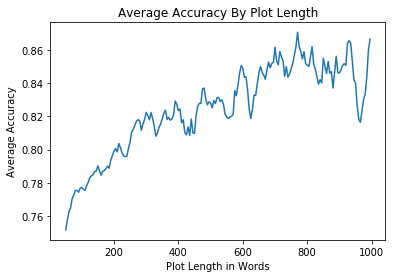

In [108]:
results = []
for x in range(50,1000,5):
    results.append({
        "plot_len":x,
        "avg_accuracy":movies_df[(movies_df['plot_len'] > x-30) & (movies_df['plot_len'] <= x)].accuracy.mean()
    })
results = pd.DataFrame(results)

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
g = sns.lineplot(x=results.plot_len, y=results.avg_accuracy, ax=ax)
g.set_title("Average Accuracy By Plot Length")
g.set_xlabel("Plot Length in Words")
g.set_ylabel("Average Accuracy")
plt.savefig("results_by_plot_len.png", bbox_inches='tight')